In [1]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.  # 之前如此
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
# print(os.listdir("../input"))  # 已更改

# Any results you write to the current directory are saved as output.

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
import time

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.8.0
sys.version_info(major=3, minor=7, micro=13, releaselevel='final', serial=0)
matplotlib 3.2.2
numpy 1.21.6
pandas 1.3.5
sklearn 1.0.2
tensorflow 2.8.0
keras.api._v2.keras 2.8.0


In [3]:
from google.colab import drive
drive.mount('/content/drive',  force_remount=True)

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/kaggle_datasets/

/content/drive/MyDrive/kaggle_datasets


In [ ]:
!nvidia-smi

Fri May  6 08:03:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 数据预处理

In [5]:
# 数据路径规整、正确是前提
train_dir = "./training/training"
valid_dir = "./validation/validation"
label_file = "./monkey_labels.txt"
print(os.path.exists(train_dir))
print(os.path.exists(valid_dir))
print(os.path.exists(label_file))

print(os.listdir(train_dir))
print(os.listdir(valid_dir))

True
True
True
['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']
['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']


In [6]:
labels = pd.read_csv(label_file, header=0)
print(labels)

   Label     Latin Name              Common Name                     \
0  n0         alouatta_palliata\t    mantled_howler                   
1  n1        erythrocebus_patas\t    patas_monkey                     
2  n2        cacajao_calvus\t        bald_uakari                      
3  n3        macaca_fuscata\t        japanese_macaque                 
4  n4       cebuella_pygmea\t        pygmy_marmoset                   
5  n5       cebus_capucinus\t        white_headed_capuchin            
6  n6       mico_argentatus\t        silvery_marmoset                 
7  n7      saimiri_sciureus\t        common_squirrel_monkey           
8  n8       aotus_nigriceps\t        black_headed_night_monkey        
9  n9       trachypithecus_johnii    nilgiri_langur                   

    Train Images    Validation Images  
0             131                  26  
1             139                  28  
2             137                  27  
3             152                  30  
4             131 

In [7]:
# 因为resnet处理的224，因此要改为
height = 224
width = 224
channels = 3
# 图形变大了，我们改小batch_size
batch_size = 24
num_classes = 10  # 类别数（10类猴子）

train_datagen = keras.preprocessing.image.ImageDataGenerator(
    # 这里也要改为resnet50，resnet50是keras中，为tf，torch都做了适配
    # preprocess_input主要做了归一化和白化
    preprocessing_function = keras.applications.resnet50.preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

# 读取图片
train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(height, width),
                                                   batch_size=batch_size,
                                                   seed=7,
                                                   shuffle=True,
                                                   class_mode="categorical")

# 这里也需要修改
valid_datagen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = keras.applications.resnet50.preprocess_input)
valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                    target_size = (height, width),
                                                    batch_size = batch_size,
                                                    seed = 7,
                                                    shuffle = False,
                                                    class_mode = "categorical")

train_num = train_generator.samples
valid_num = valid_generator.samples
print(train_num, valid_num)

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.
1098 272


In [8]:
for i in range(2):
    x, y = train_generator.next()
    print(x.shape, y.shape)
    print(y)

(24, 224, 224, 3) (24, 10)
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
(24, 224, 224, 3) (24, 10)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0

## 搭建模型

In [ ]:
resnet50_fine_tune = keras.models.Sequential()

# resnet有1000个分类，我们只有10类，最后一层要去掉，最后的输出是三维矩阵，而不是一维的
# 我们通过pooling = 'avg'解决这个问题
# pooling size 是（2，2）的时候是大小减半，而pooling size恰好等于图像大小的时候，就可以降维
resnet50_fine_tune.add(keras.applications.ResNet50(include_top=False,
                                                  pooling='avg',
                                                  # weights = 'imagenet'就会下载imagenet，在这个初始化好的基础上去训练
                                                  weights='imagenet'))
# 加一个全连接层num_classes值为10，相当于只调整最后的参数
resnet50_fine_tune.add(keras.layers.Dense(num_classes, activation='softmax'))

print(resnet50_fine_tune.layers)
resnet50_fine_tune.layers[0].trainable = True  # 这样设置会花很多时间

resnet50_fine_tune.compile(loss="categorical_crossentropy",
             optimizer="sgd", metrics=['accuracy'])

resnet50_fine_tune.summary()

[<keras.engine.functional.Functional object at 0x7fbd417cd6d0>, <keras.layers.core.dense.Dense object at 0x7fbcc9869150>]
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
Total params: 23,608,202
Trainable params: 23,555,082
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
resnet50_fine_tune.variables

[<tf.Variable 'conv1_conv/kernel:0' shape=(7, 7, 3, 64) dtype=float32, numpy=
 array([[[[ 2.82526277e-02, -1.18737184e-02,  1.51488732e-03, ...,
           -1.07003953e-02, -5.27982824e-02, -1.36667420e-03],
          [ 5.86827798e-03,  5.04415408e-02,  3.46324709e-03, ...,
            1.01423981e-02,  1.39493728e-02,  1.67549420e-02],
          [-2.44090753e-03, -4.86173332e-02,  2.69966386e-03, ...,
           -3.44439060e-04,  3.48098315e-02,  6.28910400e-03]],
 
         [[ 1.81872323e-02, -7.20698107e-03,  4.80302610e-03, ...,
           -7.43396254e-03, -8.56800564e-03,  1.16849300e-02],
          [ 1.87554304e-02,  5.12730293e-02,  4.50406177e-03, ...,
            1.39413681e-02,  1.26296384e-02, -1.73004344e-02],
          [ 1.90453827e-02, -3.87909152e-02,  4.25842637e-03, ...,
            2.75742816e-04, -1.27962548e-02, -8.35626759e-03]],
 
         [[ 1.58849321e-02, -1.06073255e-02,  1.30999666e-02, ...,
           -2.26797583e-03, -3.98984266e-04,  3.39989027e-04],
      

In [ ]:
epochs = 10
history = resnet50_fine_tune.fit_generator(train_generator,
                                           steps_per_epoch = train_num // batch_size,
                                           epochs = epochs,
                                           validation_data = valid_generator,
                                           validation_steps = valid_num // batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
45/45 [==============================] - 634s 14s/step - loss: 0.9384 - accuracy: 0.7393 - val_loss: 0.0607 - val_accuracy: 0.9811
Epoch 2/10
45/45 [==============================] - 59s 1s/step - loss: 0.1819 - accuracy: 0.9655 - val_loss: 0.0433 - val_accuracy: 0.9848
Epoch 3/10
45/45 [==============================] - 58s 1s/step - loss: 0.1027 - accuracy: 0.9814 - val_loss: 0.0447 - val_accuracy: 0.9811
Epoch 4/10
45/45 [==============================] - 59s 1s/step - loss: 0.0722 - accuracy: 0.9851 - val_loss: 0.0349 - val_accuracy: 0.9924
Epoch 5/10
45/45 [==============================] - 59s 1s/step - loss: 0.0500 - accuracy: 0.9907 - val_loss: 0.0297 - val_accuracy: 0.9924
Epoch 6/10
45/45 [==============================] - 59s 1s/step - loss: 0.0461 - accuracy: 0.9935 - val_loss: 0.0297 - val_accuracy: 0.9924
Epoch 7/10
45/45 [==============================] - 59s 1s/step - loss: 0.0272 - accuracy: 0.9972 - val_loss: 0.0221 - val_accuracy: 0.9924
Epoch 8/10
45/45 [

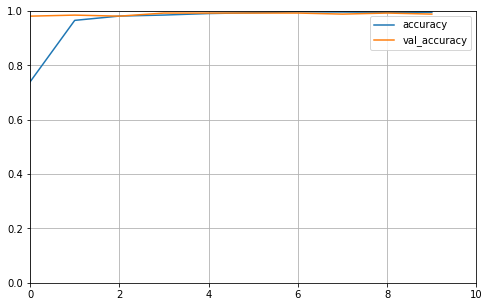

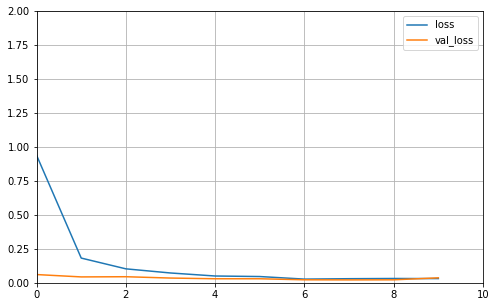

In [ ]:
def plot_learning_curves(history, label, epcohs, min_value, max_value):
    data = {}
    data[label] = history.history[label]
    data['val_'+label] = history.history['val_'+label]
    pd.DataFrame(data).plot(figsize=(8, 5))
    plt.grid(True)
    plt.axis([0, epochs, min_value, max_value])
    plt.show()
    
plot_learning_curves(history, 'accuracy', epochs, 0, 1)
plot_learning_curves(history, 'loss', epochs, 0, 2)

## 另外一种实现

In [13]:
resnet50 = keras.applications.ResNet50(include_top = False,
                                       pooling = 'avg',  # include_top为True时，pooling不起作用
                                       weights='imagenet',
                                       # classes=10
                                       )
resnet50.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                          

In [10]:
len(resnet50.layers)

177

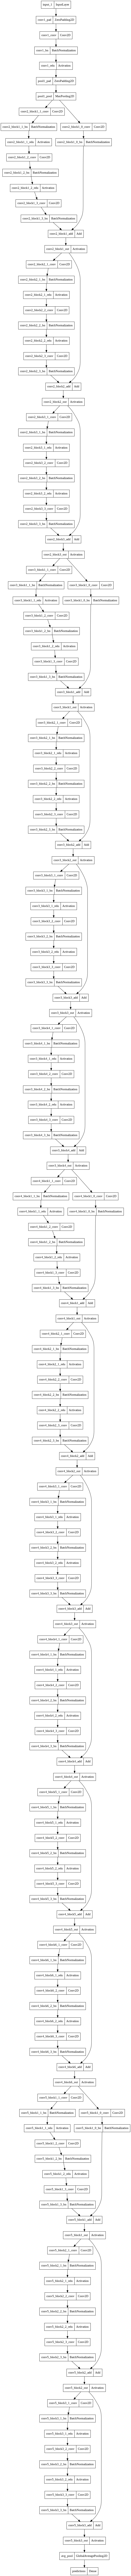

In [11]:
from tensorflow.keras.utils import plot_model

plot_model(resnet50)

In [14]:
# # 设置只有最后的5层可以训练,前面的45层不能训练
# for layer in resnet50.layers[0:-5]:
#     layer.trainable = False

resnet50_new = keras.models.Sequential([
    resnet50,
    keras.layers.Dense(num_classes, activation = 'softmax'),
])

resnet50_new.compile(loss="categorical_crossentropy",
                     optimizer="sgd", metrics=['accuracy'])
resnet50_new.summary()
# 可以看到我们的params大大增加了

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_1 (Dense)             (None, 10)                20490     
                                                                 
Total params: 23,608,202
Trainable params: 23,555,082
Non-trainable params: 53,120
_________________________________________________________________


In [15]:
# 增加了以后准确率变化了，两个原因：第二个可训练参数变多；我们增加的层进行了调整
epochs = 10
history = resnet50_new.fit_generator(train_generator,
                                     steps_per_epoch = train_num // batch_size,
                                     epochs = epochs,
                                     validation_data = valid_generator,
                                     validation_steps = valid_num // batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/10
45/45 [==============================] - 1133s 25s/step - loss: 0.8715 - accuracy: 0.7514 - val_loss: 0.1068 - val_accuracy: 0.9735
Epoch 2/10
45/45 [==============================] - 987s 22s/step - loss: 0.1897 - accuracy: 0.9590 - val_loss: 0.0566 - val_accuracy: 0.9773
Epoch 3/10
45/45 [==============================] - 1001s 22s/step - loss: 0.0996 - accuracy: 0.9786 - val_loss: 0.0393 - val_accuracy: 0.9886
Epoch 4/10
45/45 [==============================] - 990s 22s/step - loss: 0.0742 - accuracy: 0.9814 - val_loss: 0.0319 - val_accuracy: 0.9886
Epoch 5/10
45/45 [==============================] - 996s 22s/step - loss: 0.0393 - accuracy: 0.9963 - val_loss: 0.0321 - val_accuracy: 0.9962
Epoch 6/10
45/45 [==============================] - 1007s 23s/step - loss: 0.0416 - accuracy: 0.9907 - val_loss: 0.0266 - val_accuracy: 0.9924
Epoch 7/10
45/45 [==============================] - 1008s 22s/step - loss: 0.0297 - accuracy: 0.9963 - val_loss: 0.0316 - val_accuracy: 0.9962
Ep

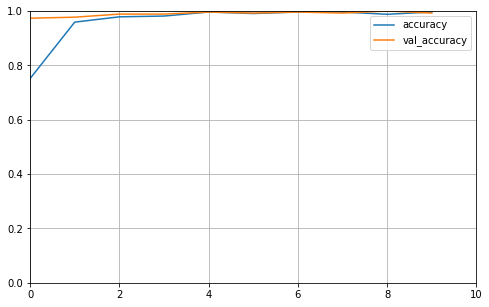

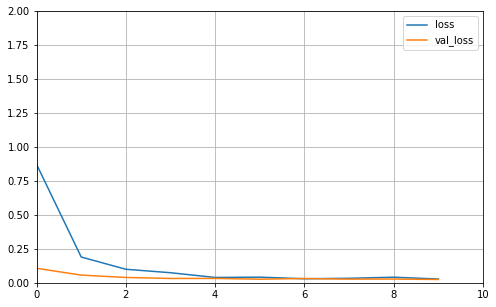

In [17]:
def plot_learning_curves(history, label, epcohs, min_value, max_value):
    data = {}
    data[label] = history.history[label]
    data['val_'+label] = history.history['val_'+label]
    pd.DataFrame(data).plot(figsize=(8, 5))
    plt.grid(True)
    plt.axis([0, epochs, min_value, max_value])
    plt.show()

plot_learning_curves(history, 'accuracy', epochs, 0, 1)
plot_learning_curves(history, 'loss', epochs, 0, 2)